In [9]:
import pytest
from cirq import Circuit as CirqCircuit
from cirq import CNOT, H, X, LineQubit, NamedQubit
from cirq.testing import assert_same_circuits
from pytket import Circuit as TketCircuit
from qiskit_ibm_runtime.fake_provider import FakeGuadalupeV2
from qiskit import QuantumCircuit as QiskitCircuit
from qiskit.converters import circuit_to_dag
from qiskit.quantum_info import Statevector
from qiskit.transpiler.passes import GatesInBasis
from qiskit.transpiler.passes.utils import CheckMap
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.circuit.library import HGate, XGate
from ucc.tests.mock_backends import Mybackend
from ucc import compile
from ucc.transpilers.ucc_defaults import UCCDefault1
import numpy as np
from qiskit.quantum_info import Operator


from collections import OrderedDict

In [10]:
import sys, site, pprint, json, pathlib
print("Interpreter:", sys.executable)
print("Site-packages dirs:")
pprint.pp(site.getsitepackages())
print("\nKernel JSON that Jupyter is using:")
kernel_file = pathlib.Path(sys.executable).parent.parent / "share" / "jupyter" / "kernels" / "myenv" / "kernel.json"
print(json.loads(kernel_file.read_text()) if kernel_file.exists() else "kernel.json not found")

Interpreter: D:\OpenSource\UnitaryHack2025\ucc_dev_2\uccvenv2\Scripts\python.exe
Site-packages dirs:
['D:\\OpenSource\\UnitaryHack2025\\ucc_dev_2\\uccvenv2',
 'D:\\OpenSource\\UnitaryHack2025\\ucc_dev_2\\uccvenv2\\Lib\\site-packages']

Kernel JSON that Jupyter is using:
kernel.json not found


In [11]:
def qcnn_circuit(N, seed=12345):
    """A circuit to generate a Quantum Convolutional Neural Network

    Parameters:
        N (int): Number of qubits

    Returns:
        QiskitCircuit: Output circuit
    """
    rng = np.random.default_rng(seed=seed)

    qc = QiskitCircuit(N)
    num_layers = int(np.ceil(np.log2(N)))
    i_conv = 0
    for i_layer in range(num_layers):
        for i_sub_layer in [0, 2**i_layer]:
            for i_q1 in range(i_sub_layer, N, 2 ** (i_layer + 1)):
                i_q2 = 2**i_layer + i_q1
                if i_q2 < N:
                    qc.rxx(rng.random(), i_q1, i_q2)
                    qc.ry(rng.random(), i_q1)
                    qc.ry(rng.random(), i_q2)
                    i_conv += 1

    return qc
    


In [12]:
import matplotlib.pyplot as plt

In [13]:
from qiskit.converters import circuit_to_dag, dag_to_circuit
def strip_idle(qc):
    dag = circuit_to_dag(qc)
    dag.remove_qubits(*dag.idle_wires())   # drops unused wires
    return dag_to_circuit(dag)

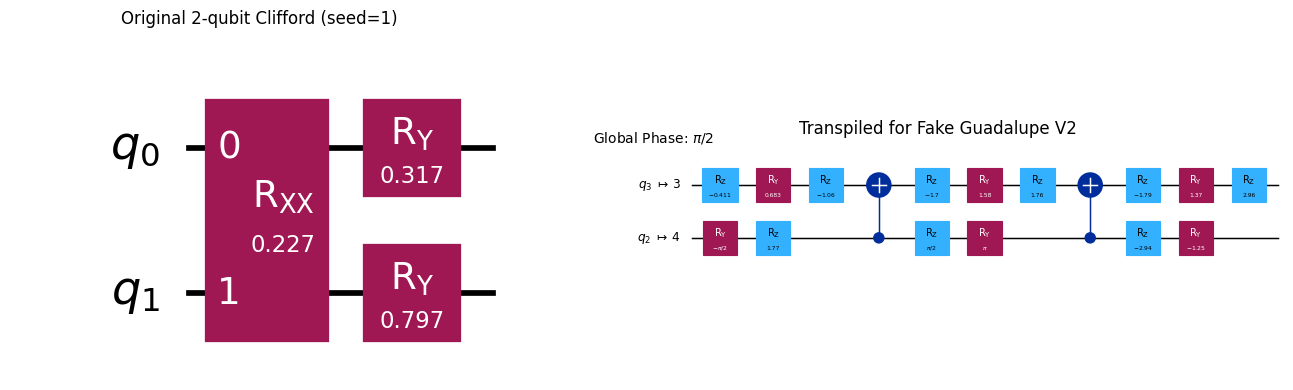

In [14]:
# --- Imports --------------------------------------------------------------
from qiskit_ibm_runtime.fake_provider import FakeLagosV2
from qiskit.circuit.random import random_clifford_circuit
from ucc.transpilers.ucc_defaults import UCCDefault1

import matplotlib.pyplot as plt
from IPython.display import display


# --- Step 1: original circuit --------------------------------------------
num_qubits = 5

orig = qcnn_circuit(2)

# --- Step 2: transpile with your pass -------------------------------------
backend   = FakeLagosV2()
ucc       = UCCDefault1(target_device=backend.target)
comp      = ucc.run(orig)

# --- Step 3: draw both circuits -------------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

orig.draw("mpl", ax=ax1)
ax1.set_title("Original 2-qubit Clifford (seed=1)")

comp.draw("mpl", ax=ax2)
ax2.set_title("Transpiled for Fake Guadalupe V2")

plt.tight_layout()
plt.show()


In [15]:
sv_orig = Statevector(orig)
sv_transpiled = Statevector(strip_idle(comp))

print(sv_orig)
print("\n****************************************\n")
print(sv_transpiled)


Statevector([0.90416624-0.00694455j, 0.14441059+0.04348041j,
             0.3808722 +0.01648593j, 0.06083171-0.10321971j],
            dims=(2, 2))

****************************************

Statevector([0.90416624-0.00694455j, 0.3808722 +0.01648593j,
             0.14441059+0.04348041j, 0.06083171-0.10321971j],
            dims=(2, 2))
